#  Chalet heat transfer analysis (EVA DMBEM Project)

### by Tatiana Fontana, Gregor Jeker and Francesco De Palo

## Chalet / Location: Zermatt CH


Let’s consider the heat transfer through a wall which separates the outside air, at temperature $T_o$ from the inside air for a Chalet in Zermatt CH in Wintertime. Heat $Q_h$ is added to the inside air by a fan-coil to compensait the ourflowing energy. Moreover, in the pictures below an iconic representation of the chalet are given.



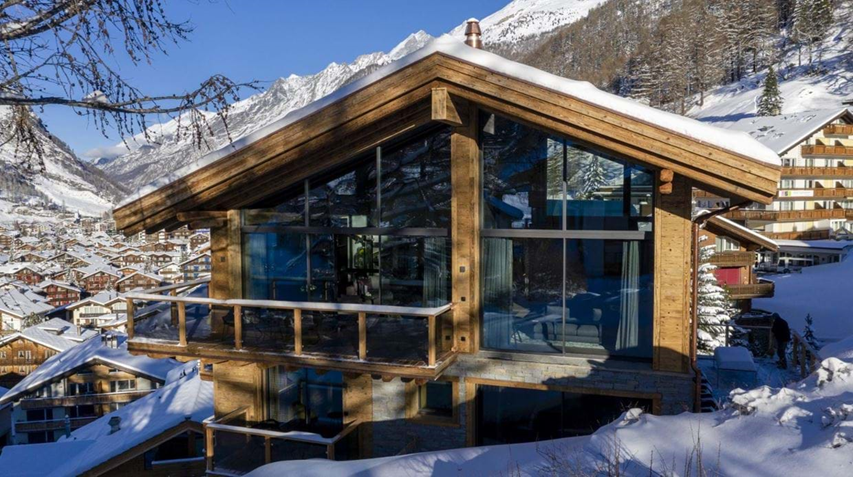

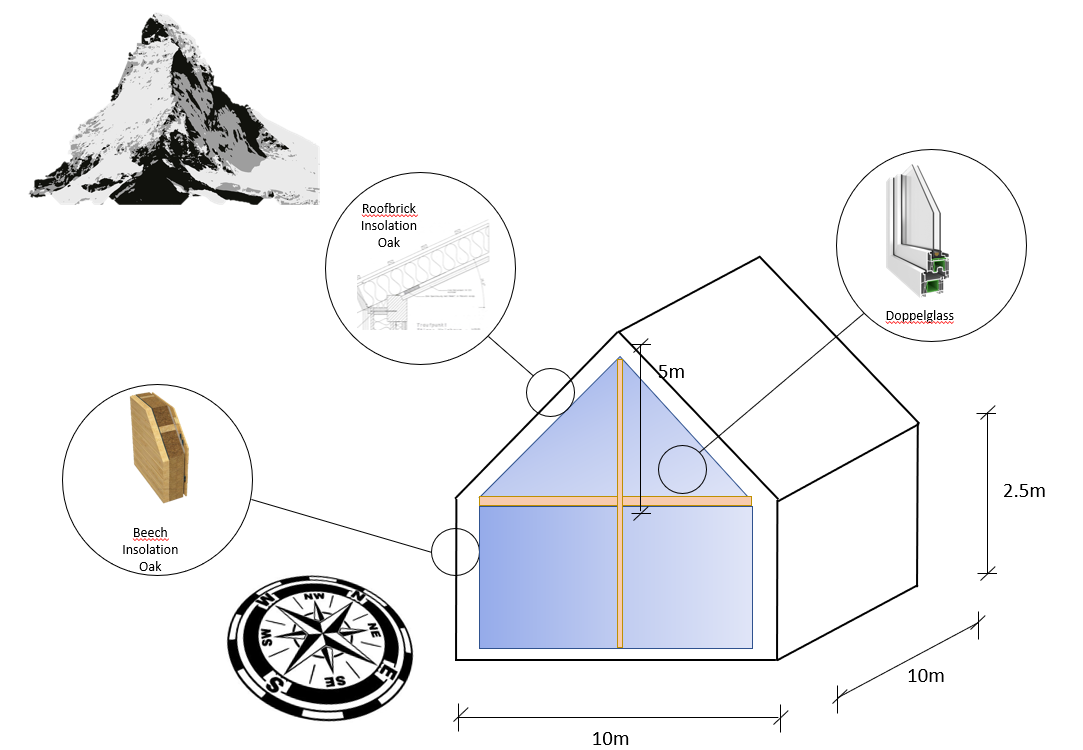

## Thermal network model


To study the thermal behaviour of the Chalet, a thermal network for all influences is created. The termal ntwork is shown in the follwoing picture.
The wall consists of three layers: exterior wood (beech), insulation and interior wood (oak). Moreover, an additional thermal circuit is derived for the roof. Every layer is discretized in 2 slices each. By adding together the resistances which are in series, the following thermal nework is obtained:

> Thermal nework model of a simple wall obtained by considering the equivalent resistances of the resistanaces in series. The model contains capacities in the nodes.

The circuit elements of the thermal network are the resistances and the capacities. Their values are found by using the thermo-physical properties of the materials.

The thermal circuits built for every wall is shown in the figure below:

![cube](tc_chalet.JPG)

Firstly, all the relevant packages are loaded on this notebook:

In [1]:
from dm4bem import read_epw, sol_rad_tilt_surf
import numpy as np
import pandas as pd
from dm4bem import read_epw, sol_rad_tilt_surf
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem
import math
from dm4bem import read_epw, sol_rad_tilt_surf
import tuto

The thermal properties of the wall and air are:

In [2]:
wall = {'Conductivity': [0.18,0.040,0.12,0.08,1.4],
        'Density': [800, 16, 600, 2000, 2500],
        'Specific heat': [2385, 1210, 2385, 920, 750],
        'Width': [0.1, 0.2, 0.1, 0.2, 0.02],
        'Slices': [ 2, 2, 2, 2, 1]}

wall = pd.DataFrame(wall, index=['Beech', 'Insulation', 'Oak','Brick','Glass'])



air = {'Density': 1.007,
       'Specific heat': 1150}

# altitude: 1608 m

In [3]:
wall

,Conductivity,Density,Specific heat,Width,Slices
Beech,0.18,800,2385,0.10,2
Insulation,0.04,16,1210,0.20,2
Oak,0.12,600,2385,0.10,2
Brick,0.08,2000,920,0.20,2
Glass,1.40,2500,750,0.02,1


## Hypothesis of the project

- The purpose of this project is to study the thermal behaviour of the before-mentioned building
- A deeper insight will be given about diffrent control systems for the indoor temperature:
    - P - contoller
    - P - contoller with feedback
    - predictive controller
    We want to verify if the predictive controller is the most efficient one.
- We want also to assess the influence of some parameters on the output response. (blinds, changing materials)

The simplification we considered in our assessment are:
- homogeneous materials in the walls
- adiabatic ground
- constant properties of fluids and solids
- constant albedo 
- average of 4 people in the chalet 
- average properties of air for an elevation of 1608 m
- constant air infiltration 
- solar radiation between walls on the interior side neglectible
- the effect of blinds tilt is taken into account through changing the transmissivity of the glass

${\LARGE \textrm{Weather data and solar radiation computations }}$

# Obtain weather data from EnergyPlus files

 

## Read weather data


In [4]:
from dm4bem import read_epw, sol_rad_tilt_surf
import numpy as np
import pandas as pd

filename = 'CHE_VS_Zermatt.067480_TMYx.2004-2018.epw'


In weather file, data corresponding to each month is from another year. 

In [5]:
[data, meta] = read_epw(filename, coerce_year=None)
month_year = data['month'].astype(str) + '-' + data['year'].astype(str)
print(f"Months - years in the dataset: {sorted(set(month_year))}")

Months - years in the dataset: ['1-2012', '10-2008', '11-2012', '12-2007', '2-2015', '3-2007', '4-2017', '5-2006', '6-2015', '7-2016', '8-2013', '9-2013']


${\LARGE \textrm{Weather data and solar radiation computations }}$

In [6]:
from dm4bem import read_epw, sol_rad_tilt_surf
import numpy as np
import pandas as pd

filename = 'CHE_VS_Zermatt.067480_TMYx.2004-2018.epw'


In weather file, data corresponding to each month is from another year. 

In [7]:
[data, meta] = read_epw(filename, coerce_year=None)
month_year = data['month'].astype(str) + '-' + data['year'].astype(str)
print(f"Months - years in the dataset: {sorted(set(month_year))}")

Months - years in the dataset: ['1-2012', '10-2008', '11-2012', '12-2007', '2-2015', '3-2007', '4-2017', '5-2006', '6-2015', '7-2016', '8-2013', '9-2013']


From the dataset, select air temperature, normal solar radiation and diffuse solar radiation received during 60 minutes prior to timestamp. It is changed to the same year (2012)

In [8]:
weather_data = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
weather_data.index = weather_data.index.map(lambda t: t.replace(year=2012))

A period of one month is selected (January 2012). The air temperature, normal solar radiation and diffuse solar radiation received during 60 minutes prior to timestamp are selected. 

In [9]:
start_date = '2012-1-1'
end_date = '2012-2-1'

weather_data = weather_data[(weather_data.index >= start_date) & (
    weather_data.index < end_date)]
del data

<AxesSubplot:>

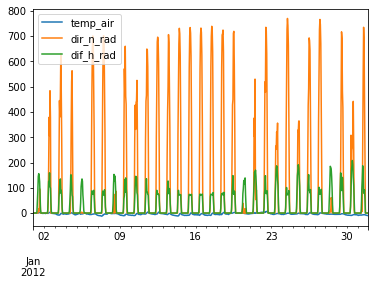

In [10]:
weather_data.plot()

## Solar radiation on the tilted surface of the chalet

Given a tilted wall and knowing the albedo of the surface in front of it, we have calculated the direct, diffuse and reflected radiation incident on the walls and on the roof. In this presentation, the north wall will be analysed in depth first, then the others follow without further explanations.

<AxesSubplot:>

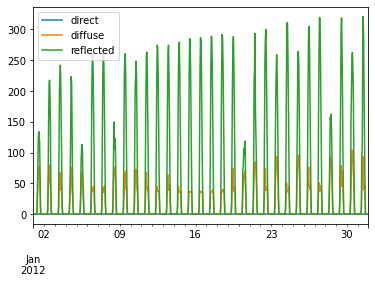

In [11]:
surface_orientation_N = {'slope': 90,
                       'azimuth': 180,
                       'latitude': 46}
albedo_ground = 0.2
albedo_snow = 0.9
albedo = 0.9*albedo_snow + 0.1*albedo_ground

rad_surf_N = sol_rad_tilt_surf(
    weather_data, surface_orientation_N, albedo)

rad_surf_N.plot()

# Solar radiation on the tilted surface 

Let’s consider a tilted surface having another surface (e.g., ground) in front of it. Given the weather data, the surface orientation, and the albedo of the ground in front of the surface, find the direct, diffuse and reflected solar radiation for this surface. 

In [12]:
import numpy as np
import pandas as pd

B = surface_orientation_N['slope']
Z = surface_orientation_N['azimuth']
L = surface_orientation_N['latitude']

# Transform degrees in radians
B = B * np.pi / 180
Z = Z * np.pi / 180
L = L * np.pi / 180

n = weather_data.index.dayofyear

**Total solar radiation** is the amount of radiation received on a surface during the number of minutes preceding the time indicated:

$$ G_{sr} = G_{dir} + G_{dif} + G_r$$

where:

- $G_{dir}$ **direct normal** or **beam radiation**: amount of solar radiation received directly from the solar disk on a surface perpendicular to the sun’s rays, during the number of minutes preceding the time indicated, Wh/m².

- $G_{dif}$ **diffuse radiation**: amount of solar radiation received after scattering by the atmosphere, Wh/m². Note: it does not include the diffuse infrared radiation emitted by the atmosphere.

- $G_r$ **total solar radiation coming by reflection** from the surface in front of the wall (usually, ground), Wh/m².

## Direct radiation, $G_{dir}$

The direct radiation on the surface, $G_{dir}$, depends on the *direct normal (or beam) radiation*, $G_n$, and the *incidence angle*, $\theta$, between the solar beam and the normal to the wall [2] (§11.2.1).

In order to calculate the *incidence angle*, $\theta$, we need:

- $\phi$ *latitude*, the angle between the position and the Equator, ranging from 0° at the Equator to 90° at the North Pole and -90° at the South Pole. $-90 ^{\circ} \leq \phi \leq 90 ^{\circ}$

- $\beta$ *slope*, the angle between the plane of the surface and the horizontal. $\beta > 90 ^{\circ}$

- $\gamma$ *azimuth*, the angle between the projection on a horizontal plane of the normal to the surface and the local meridian; south is zero, east negative, and west positive. $-180 ^{\circ} \leq \gamma \leq 180 ^{\circ}$.

- $\delta$ *declination angle*, the angle between the sun at noon (i.e., when the sun is on the local meridian) and the plane of the equator, north positive [1](eq. 1.6.1a), [2](§11.2.1.1, eq. (78)):
$$ \delta = 23.45 \sin \left( 360 \frac{284 + n}{365} \right)$$

In [13]:
declination_angle = 23.45 * np.sin(360 * (284 + n) / 365 * np.pi / 180)
d = declination_angle * np.pi / 180

- $\omega$ *hour angle*, the angle between the sun and the local meridian due to rotation of the earth around its axis at 15° per hour [1]:

$$ \omega = 15\left ( hour + \frac{minute}{60} - 12 \right )$$

where *hour* and *minute* is the solar time:

In [14]:
hour = weather_data.index.hour
minute = weather_data.index.minute + 60
hour_angle = 15 * ((hour + minute / 60) - 12)
h = hour_angle * np.pi / 180

$-180 ^{\circ} \leq \omega \leq 180 ^{\circ}$. $\omega < 0$ in the morning, $\omega = 0$ at noon, and $\omega > 0$ in the afternoon. Hour angle is used with the declination to give the direction of  apoint on the celestial sphere.

The **incidence angle**, $\theta$, is the angle between the solar beam on the surface and the normal to the surface [1](eq. 1.6.2), [2] (eq. 78):

$$\theta = \arccos (\sin \delta \sin \phi \cos \beta - \sin \delta \cos \phi \sin \beta \cos \gamma + \cos \delta \cos \phi \cos \beta \cos \omega + \cos \delta \sin \phi \sin \beta \cos \gamma \cos \omega + \cos \delta \sin \beta \sin \gamma \sin \omega)$$

In [15]:
theta = np.sin(d) * np.sin(L) * np.cos(B)
theta -= np.sin(d) * np.cos(L) * np.sin(B) * np.cos(Z)
theta += np.cos(d) * np.cos(L) * np.cos(B) * np.cos(h)
theta += np.cos(d) * np.sin(L) * np.sin(B) * np.cos(Z) * np.cos(h)
theta += np.cos(d) * np.sin(B) * np.sin(Z) * np.sin(h)
theta = np.array(np.arccos(theta))
theta[theta > (np.pi / 2)] = np.pi / 2

The **direct radiation**, $G_{dir}$ on the surface is:

$$G_{dir} = G_{dir,n} \cos \theta$$

where *direct normal radiation* or *beam radiation*, $G_n$, is the amount of solar radiation (in Wh/m²) received directly from the solar disk on the surface perpendicular to the sun’s rays, during the number of minutes preceding the time indicated. It is given by weather data.

In [16]:
dir_rad = weather_data["dir_n_rad"] * np.cos(theta)
dir_rad[dir_rad < 0] = 0

## Diffuse Radiation, $G_{dif}$

The diffuse radiation on the wall is a function on its slope, $\beta$, and 
the isotropic diffuse solar radiation, $G_{dif,h}$, [2](§1.2.1.2, eq. 79, p. 31):

$$ G_{dif} = G_{dif,h} (1 + \cos \beta) / 2$$

In [17]:
dif_rad = weather_data["dif_h_rad"] * (1 + np.cos(B)) / 2

## Solar radiation reflected by the ground

Considering the radiation reflected by the ground as isotropic, the reflected radiation that gets onto the wall is a function of its slope, albedo and total horizontal radaition [2](§11.2.1.3).

The normal horizontal radiation is [2] (eq. 80):
$$ G_{dir,h} = G_{dn} \sin \gamma$$

In [18]:
gamma = np.cos(d) * np.cos(L) * np.cos(h)
gamma += np.sin(d) * np.sin(L)
gamma = np.array(np.arcsin(gamma))
gamma[gamma < 1e-5] = 1e-5

dir_h_rad = weather_data["dir_n_rad"] * np.sin(gamma)

The total radiation received by reflection is:
$$G_r = (G_{dir,h} + G_{dif,h}) albedo (1 - \cos \beta)/2$$

In [19]:
ref_rad = (dir_h_rad + weather_data["dif_h_rad"]) * albedo
ref_rad *= (1 - np.cos(B) / 2)

## Total radiation on one wall

Finally, the total radiation, intended as the sum of the diffuse, reflected and normal radiation components is calculated

<AxesSubplot:>

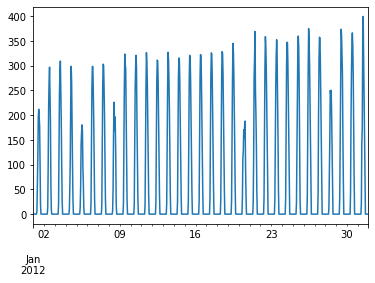

In [20]:
tot_rad_N = ref_rad + dif_rad + dir_rad
tot_rad_N.plot()

## Radiation computations for East wall 

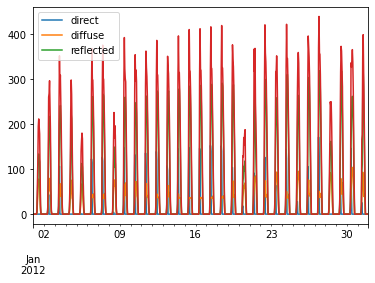

In [21]:
surface_orientation_E = {'slope': 90,
                       'azimuth': -90,
                       'latitude': 46}

rad_surf_E = sol_rad_tilt_surf(
    weather_data, surface_orientation_E, albedo)

rad_surf_E.plot()


B = surface_orientation_E['slope']
Z = surface_orientation_E['azimuth']
L = surface_orientation_E['latitude']

# Transform degrees in radians
B = B * np.pi / 180
Z = Z * np.pi / 180
L = L * np.pi / 180

n = weather_data.index.dayofyear

declination_angle = 23.45 * np.sin(360 * (284 + n) / 365 * np.pi / 180)
d = declination_angle * np.pi / 180

hour = weather_data.index.hour
minute = weather_data.index.minute + 60
hour_angle = 15 * ((hour + minute / 60) - 12)
h = hour_angle * np.pi / 180

theta = np.sin(d) * np.sin(L) * np.cos(B)
theta -= np.sin(d) * np.cos(L) * np.sin(B) * np.cos(Z)
theta += np.cos(d) * np.cos(L) * np.cos(B) * np.cos(h)
theta += np.cos(d) * np.sin(L) * np.sin(B) * np.cos(Z) * np.cos(h)
theta += np.cos(d) * np.sin(B) * np.sin(Z) * np.sin(h)
theta = np.array(np.arccos(theta))
theta[theta > (np.pi / 2)] = np.pi / 2

dir_rad = weather_data["dir_n_rad"] * np.cos(theta)
dir_rad[dir_rad < 0] = 0

dif_rad = weather_data["dif_h_rad"] * (1 + np.cos(B)) / 2

gamma = np.cos(d) * np.cos(L) * np.cos(h)
gamma += np.sin(d) * np.sin(L)
gamma = np.array(np.arcsin(gamma))
gamma[gamma < 1e-5] = 1e-5

dir_h_rad = weather_data["dir_n_rad"] * np.sin(gamma)

ref_rad = (dir_h_rad + weather_data["dif_h_rad"]) * albedo
ref_rad *= (1 - np.cos(B) / 2)

tot_rad_E = ref_rad + dif_rad + dir_rad
tot_rad_E.plot()

tot_rad_E.to_csv(r'C:\Users\Mario\Desktop\ZHAW_modules\HS2021\EVA_DMBEM\eva_DMBEM-main\tot_rad_E.csv')


## Radiation computations on South wall 

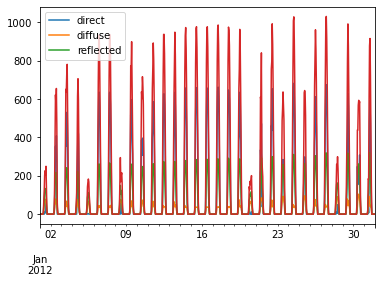

In [22]:
surface_orientation_S = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 46}

rad_surf_S = sol_rad_tilt_surf(
    weather_data, surface_orientation_S, albedo)

rad_surf_S.plot()


B = surface_orientation_S['slope']
Z = surface_orientation_S['azimuth']
L = surface_orientation_S['latitude']

# Transform degrees in radians
B = B * np.pi / 180
Z = Z * np.pi / 180
L = L * np.pi / 180

n = weather_data.index.dayofyear

declination_angle = 23.45 * np.sin(360 * (284 + n) / 365 * np.pi / 180)
d = declination_angle * np.pi / 180

hour = weather_data.index.hour
minute = weather_data.index.minute + 60
hour_angle = 15 * ((hour + minute / 60) - 12)
h = hour_angle * np.pi / 180

theta = np.sin(d) * np.sin(L) * np.cos(B)
theta -= np.sin(d) * np.cos(L) * np.sin(B) * np.cos(Z)
theta += np.cos(d) * np.cos(L) * np.cos(B) * np.cos(h)
theta += np.cos(d) * np.sin(L) * np.sin(B) * np.cos(Z) * np.cos(h)
theta += np.cos(d) * np.sin(B) * np.sin(Z) * np.sin(h)
theta = np.array(np.arccos(theta))
theta[theta > (np.pi / 2)] = np.pi / 2

dir_rad = weather_data["dir_n_rad"] * np.cos(theta)
dir_rad[dir_rad < 0] = 0

dif_rad = weather_data["dif_h_rad"] * (1 + np.cos(B)) / 2

gamma = np.cos(d) * np.cos(L) * np.cos(h)
gamma += np.sin(d) * np.sin(L)
gamma = np.array(np.arcsin(gamma))
gamma[gamma < 1e-5] = 1e-5

dir_h_rad = weather_data["dir_n_rad"] * np.sin(gamma)

ref_rad = (dir_h_rad + weather_data["dif_h_rad"]) * albedo
ref_rad *= (1 - np.cos(B) / 2)

tot_rad_S = ref_rad + dif_rad + dir_rad
tot_rad_S.plot()

tot_rad_S.to_csv(r'C:\Users\Mario\Desktop\ZHAW_modules\HS2021\EVA_DMBEM\eva_DMBEM-main\tot_rad_S.csv')

## Radiation computations on West wall

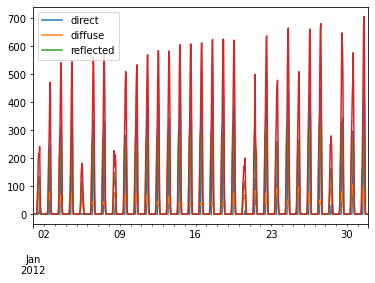

In [23]:
surface_orientation_W = {'slope': 90,
                       'azimuth': 90,
                       'latitude': 46}

rad_surf_W = sol_rad_tilt_surf(
    weather_data, surface_orientation_W, albedo)

rad_surf_W.plot()


B = surface_orientation_W['slope']
Z = surface_orientation_W['azimuth']
L = surface_orientation_W['latitude']

# Transform degrees in radians
B = B * np.pi / 180
Z = Z * np.pi / 180
L = L * np.pi / 180

n = weather_data.index.dayofyear

declination_angle = 23.45 * np.sin(360 * (284 + n) / 365 * np.pi / 180)
d = declination_angle * np.pi / 180

hour = weather_data.index.hour
minute = weather_data.index.minute + 60
hour_angle = 15 * ((hour + minute / 60) - 12)
h = hour_angle * np.pi / 180

theta = np.sin(d) * np.sin(L) * np.cos(B)
theta -= np.sin(d) * np.cos(L) * np.sin(B) * np.cos(Z)
theta += np.cos(d) * np.cos(L) * np.cos(B) * np.cos(h)
theta += np.cos(d) * np.sin(L) * np.sin(B) * np.cos(Z) * np.cos(h)
theta += np.cos(d) * np.sin(B) * np.sin(Z) * np.sin(h)
theta = np.array(np.arccos(theta))
theta[theta > (np.pi / 2)] = np.pi / 2

dir_rad = weather_data["dir_n_rad"] * np.cos(theta)
dir_rad[dir_rad < 0] = 0

dif_rad = weather_data["dif_h_rad"] * (1 + np.cos(B)) / 2

gamma = np.cos(d) * np.cos(L) * np.cos(h)
gamma += np.sin(d) * np.sin(L)
gamma = np.array(np.arcsin(gamma))
gamma[gamma < 1e-5] = 1e-5

dir_h_rad = weather_data["dir_n_rad"] * np.sin(gamma)

ref_rad = (dir_h_rad + weather_data["dif_h_rad"]) * albedo
ref_rad *= (1 - np.cos(B) / 2)

tot_rad_W = ref_rad + dif_rad + dir_rad
tot_rad_W.plot()

tot_rad_W.to_csv(r'C:\Users\Mario\Desktop\ZHAW_modules\HS2021\EVA_DMBEM\eva_DMBEM-main\tot_rad_W.csv')


## Radiation computations on the East tilted wall (East roof)

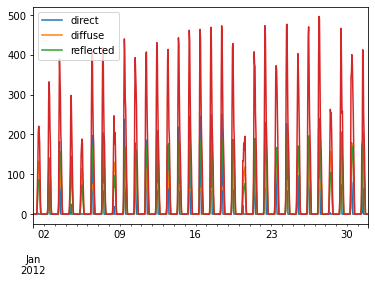

In [24]:
surface_orientation_ER = {'slope': 45,
                       'azimuth': -90,
                       'latitude': 46}

rad_surf_ER = sol_rad_tilt_surf(
    weather_data, surface_orientation_ER, albedo)

rad_surf_ER.plot()


B = surface_orientation_ER['slope']
Z = surface_orientation_ER['azimuth']
L = surface_orientation_ER['latitude']

# Transform degrees in radians
B = B * np.pi / 180
Z = Z * np.pi / 180
L = L * np.pi / 180

n = weather_data.index.dayofyear

declination_angle = 23.45 * np.sin(360 * (284 + n) / 365 * np.pi / 180)
d = declination_angle * np.pi / 180

hour = weather_data.index.hour
minute = weather_data.index.minute + 60
hour_angle = 15 * ((hour + minute / 60) - 12)
h = hour_angle * np.pi / 180

theta = np.sin(d) * np.sin(L) * np.cos(B)
theta -= np.sin(d) * np.cos(L) * np.sin(B) * np.cos(Z)
theta += np.cos(d) * np.cos(L) * np.cos(B) * np.cos(h)
theta += np.cos(d) * np.sin(L) * np.sin(B) * np.cos(Z) * np.cos(h)
theta += np.cos(d) * np.sin(B) * np.sin(Z) * np.sin(h)
theta = np.array(np.arccos(theta))
theta[theta > (np.pi / 2)] = np.pi / 2

dir_rad = weather_data["dir_n_rad"] * np.cos(theta)
dir_rad[dir_rad < 0] = 0

dif_rad = weather_data["dif_h_rad"] * (1 + np.cos(B)) / 2

gamma = np.cos(d) * np.cos(L) * np.cos(h)
gamma += np.sin(d) * np.sin(L)
gamma = np.array(np.arcsin(gamma))
gamma[gamma < 1e-5] = 1e-5

dir_h_rad = weather_data["dir_n_rad"] * np.sin(gamma)

ref_rad = (dir_h_rad + weather_data["dif_h_rad"]) * albedo
ref_rad *= (1 - np.cos(B) / 2)

tot_rad_ER = ref_rad + dif_rad + dir_rad
tot_rad_ER.plot()

tot_rad_ER.to_csv(r'C:\Users\Mario\Desktop\ZHAW_modules\HS2021\EVA_DMBEM\eva_DMBEM-main\tot_rad_ER.csv')


## Radiation computations on West tilted wall (West roof)

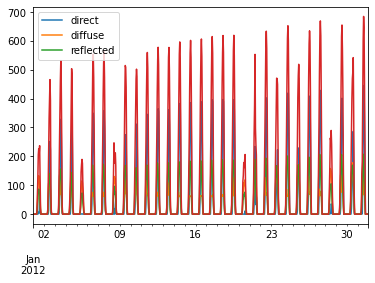

In [25]:
surface_orientation_WR = {'slope': 45,
                       'azimuth': 90,
                       'latitude': 46}

rad_surf_WR = sol_rad_tilt_surf(
    weather_data, surface_orientation_WR, albedo)

rad_surf_WR.plot()


B = surface_orientation_WR['slope']
Z = surface_orientation_WR['azimuth']
L = surface_orientation_WR['latitude']

# Transform degrees in radians
B = B * np.pi / 180
Z = Z * np.pi / 180
L = L * np.pi / 180

n = weather_data.index.dayofyear

declination_angle = 23.45 * np.sin(360 * (284 + n) / 365 * np.pi / 180)
d = declination_angle * np.pi / 180

hour = weather_data.index.hour
minute = weather_data.index.minute + 60
hour_angle = 15 * ((hour + minute / 60) - 12)
h = hour_angle * np.pi / 180

theta = np.sin(d) * np.sin(L) * np.cos(B)
theta -= np.sin(d) * np.cos(L) * np.sin(B) * np.cos(Z)
theta += np.cos(d) * np.cos(L) * np.cos(B) * np.cos(h)
theta += np.cos(d) * np.sin(L) * np.sin(B) * np.cos(Z) * np.cos(h)
theta += np.cos(d) * np.sin(B) * np.sin(Z) * np.sin(h)
theta = np.array(np.arccos(theta))
theta[theta > (np.pi / 2)] = np.pi / 2

dir_rad = weather_data["dir_n_rad"] * np.cos(theta)
dir_rad[dir_rad < 0] = 0

dif_rad = weather_data["dif_h_rad"] * (1 + np.cos(B)) / 2

gamma = np.cos(d) * np.cos(L) * np.cos(h)
gamma += np.sin(d) * np.sin(L)
gamma = np.array(np.arcsin(gamma))
gamma[gamma < 1e-5] = 1e-5

dir_h_rad = weather_data["dir_n_rad"] * np.sin(gamma)

ref_rad = (dir_h_rad + weather_data["dif_h_rad"]) * albedo
ref_rad *= (1 - np.cos(B) / 2)

tot_rad_WR = ref_rad + dif_rad + dir_rad
tot_rad_WR.plot()

tot_rad_WR.to_csv(r'C:\Users\Mario\Desktop\ZHAW_modules\HS2021\EVA_DMBEM\eva_DMBEM-main\tot_rad_WR.csv')


## Radiation computations on Ground wall

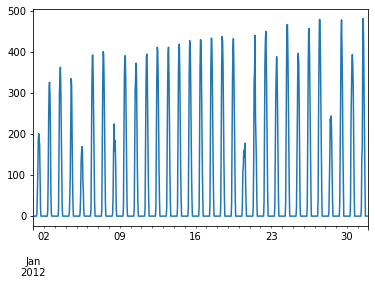

In [26]:
surface_orientation_G = {'slope': 180,
                       'azimuth': 90,
                       'latitude': 46}

rad_surf_G = sol_rad_tilt_surf(
    weather_data, surface_orientation_G, albedo)

B = surface_orientation_G['slope']
Z = surface_orientation_G['azimuth']
L = surface_orientation_G['latitude']

# Transform degrees in radians
B = B * np.pi / 180
Z = Z * np.pi / 180
L = L * np.pi / 180

n = weather_data.index.dayofyear

declination_angle = 23.45 * np.sin(360 * (284 + n) / 365 * np.pi / 180)
d = declination_angle * np.pi / 180

hour = weather_data.index.hour
minute = weather_data.index.minute + 60
hour_angle = 15 * ((hour + minute / 60) - 12)
h = hour_angle * np.pi / 180

theta = np.sin(d) * np.sin(L) * np.cos(B)
theta -= np.sin(d) * np.cos(L) * np.sin(B) * np.cos(Z)
theta += np.cos(d) * np.cos(L) * np.cos(B) * np.cos(h)
theta += np.cos(d) * np.sin(L) * np.sin(B) * np.cos(Z) * np.cos(h)
theta += np.cos(d) * np.sin(B) * np.sin(Z) * np.sin(h)
theta = np.array(np.arccos(theta))
theta[theta > (np.pi / 2)] = np.pi / 2

dir_rad = weather_data["dir_n_rad"] * np.cos(theta)
dir_rad[dir_rad < 0] = 0

dif_rad = weather_data["dif_h_rad"] * (1 + np.cos(B)) / 2

gamma = np.cos(d) * np.cos(L) * np.cos(h)
gamma += np.sin(d) * np.sin(L)
gamma = np.array(np.arcsin(gamma))
gamma[gamma < 1e-5] = 1e-5

dir_h_rad = weather_data["dir_n_rad"] * np.sin(gamma)

ref_rad = (dir_h_rad + weather_data["dif_h_rad"]) * albedo
ref_rad *= (1 - np.cos(B) / 2)

tot_rad_G = ref_rad + dif_rad + dir_rad
tot_rad_G.plot()

tot_rad_WR.to_csv(r'C:\Users\Mario\Desktop\ZHAW_modules\HS2021\EVA_DMBEM\eva_DMBEM-main\tot_rad_G.csv')

## Definitions

$G_{dir,n}$ **Direct normal** or **beam radiation**. Amount of solar radiation in Wh/m² received directly from the solar disk on a surface perpendicular to the sun’s rays, during the number of minutes preceding the time indicated.

$G_{dif,h}$ **Diffuse horizontal radiation**. Amount of solar radiation in Wh/m² received after scattering by the atmosphere. This definition distinguishes the diffuse solar radiation from infrared radiation emitted by the atmosphere.

**Total Solar Radiation**. Total amount of direct and diffuse solar radiation in Wh/m² received on a  surface during the number of minutes preceding the time indicated.

**Global radiation.** Total solar radiation given on a horizontal surface.

**Solar Time.** Time based on the apparent position of the sun in the sky with noon the time when the sun crosses the observer meridian. 

## Definitions for angles (in degrees)

$\phi$ **Latitude.** Angle between the position and the Equator, ranging from 0° at the Equator to 90° at the North Pole and -90° at the South Pole. $-90 ^{\circ} \leq \phi \leq 90 ^{\circ}$

$\beta$ **Slope.** Angle between the plane of the surface and the horizontal. $\beta > 90 ^{\circ}$

$\gamma$ **Azimuth.** Angle between the projection on a horizontal plane of the normal to the surface and the local meridian; south is zero, east negative, and west positive. $-180 ^{\circ} \leq \gamma \leq 180 ^{\circ}$.

$\delta$ **Declination.** Angle between the sun at noon (i.e., when the sun is on the local meridian) and the plane of the equator, north positive [1, eq. 1.6.1a):

$$ \delta = 23.45 \sin \left( 360 \frac{284 + n}{365} \right)$$

where $n$ is the day of the year. $-23.45 ^{\circ} \leq \delta \leq 23.45 ^{\circ}$. Declination is used with hour angle to give the direction of apoint on the celestial sphere.

$\omega$ **Hour angle.** Angle between the sun and the local meridian due to rotation of the earth around its axis at 15° per hour [1]:

$$ \omega = 15\left ( hour + \frac{minute}{60} - 12 \right )$$

where *hour* and *minute* is the solar time. $-180 ^{\circ} \leq \omega \leq 180 ^{\circ}$; $\omega < 0$ in the morning, $\omega = 0$ at noon, and $\omega > 0$ in the afternoon. Hour angle is used with the declination to give the direction of  apoint on the celestial sphere.

$\theta$ **Incidence.** Angle between the solar beam on the surface and the normal to the surface [1, eq. 1.6.2]:

$$\theta = \arccos (\sin \delta \sin \phi \cos \beta - \sin \delta \cos \phi \sin \beta \cos \gamma + \cos \delta \cos \phi \cos \beta \cos \omega + \cos \delta \sin \phi \sin \beta \cos \gamma \cos \omega + \cos \delta \sin \beta \sin \gamma \sin \omega)$$



# References

1. J.A. Duffie, W. A. Beckman, N. Blair (2020) Solar Engineering of Thermal Processes, 5th ed. John Wiley & Sons, Inc. ISBN 9781119540281

2. Réglementation Thermique 2005. Méthode de calcul Th-CE. Annexe à l’arrêté du 19 juillet 2006

# Thermal Circuit assembling of the building

Firstly, all the relevant information regarding radiations and outdoor temperature (computed before) are extracted:

In [27]:
rad_E = pd.read_csv(r'C:\Users\Mario\Desktop\ZHAW_modules\HS2021\EVA_DMBEM\eva_DMBEM-main\tot_rad_E.csv')
rad_E.rename(columns={'0': 'WData'}, inplace=True)

rad_ER = pd.read_csv(r'C:\Users\Mario\Desktop\ZHAW_modules\HS2021\EVA_DMBEM\eva_DMBEM-main\tot_rad_ER.csv')
rad_ER.rename(columns={'0': 'WData'}, inplace=True)

rad_G = pd.read_csv(r'C:\Users\Mario\Desktop\ZHAW_modules\HS2021\EVA_DMBEM\eva_DMBEM-main\tot_rad_G.csv')
rad_G.rename(columns={'0': 'WData'}, inplace=True)

rad_N = pd.read_csv(r'C:\Users\Mario\Desktop\ZHAW_modules\HS2021\EVA_DMBEM\eva_DMBEM-main\tot_rad_N.csv')
rad_N.rename(columns={'0': 'WData'}, inplace=True)

rad_S = pd.read_csv(r'C:\Users\Mario\Desktop\ZHAW_modules\HS2021\EVA_DMBEM\eva_DMBEM-main\tot_rad_S.csv')
rad_S.rename(columns={'0': 'WData'}, inplace=True)

rad_W = pd.read_csv(r'C:\Users\Mario\Desktop\ZHAW_modules\HS2021\EVA_DMBEM\eva_DMBEM-main\tot_rad_W.csv')
rad_W.rename(columns={'0': 'WData'}, inplace=True)

rad_WR = pd.read_csv(r'C:\Users\Mario\Desktop\ZHAW_modules\HS2021\EVA_DMBEM\eva_DMBEM-main\tot_rad_WR.csv')
rad_WR.rename(columns={'0': 'WData'}, inplace=True)

T_out = pd.read_csv(r'C:\Users\Mario\Desktop\ZHAW_modules\HS2021\EVA_DMBEM\eva_DMBEM-main\T_out.csv')

In [28]:
air

{'Density': 1.007, 'Specific heat': 1150}

We'll consider the convection coefficients for indoor and outdoor, regarding the outdoor one an adequate correlation is chosen for the estimation while for the indoor one is considered to be equal to a standard value:

In [29]:
# convection coefficients, W/m² K

# estimation of the outer convection coefficient by using the following empirical formula:

nu = 12.94e-6
Too = 268.15
beta = 1/Too
g = 9.81
DT = 10
L = 10
Gr = (g*beta*DT*(L**3))/(nu**2)
k_air = 0.046
mu = nu*1.007
Pr = (mu*1150)/k_air
Ra = Gr*Pr
Nu = 0.1*(Ra**(1/3))
h_out = Nu*k_air/L 

h = pd.DataFrame([{'in': 4., 'out': h_out}])

The dimensions of the walls are 10 x 3 m² (vertical walls) and the volume of the indoor air is defined below considering also the thickness of each wall.
We can also define the mass of air per second passing through the chalet due to ventilation.

In [30]:
# Walls

S_wall_big = 10*2.5 + 25
S_wall = 10*2.5
S_roof = S_wall + 25

V_air = 9.6 * 9.6 * 3 + ((10/math.sqrt(2))*9.6*0.5)  # m³
m_dot = 0.3*V_air*air['Density']/3600

### Resistances and capacities in the thermal network

The thermal resistances for conduction are of the form:
$$R_{cd} = \frac{w}{\lambda S}$$
where:

- $w$ is the width of the material, m;
- $\lambda$ - thermal conductvity, W/m K;
- $S$ - surface area of the wall, m²

In [31]:
# conduction (big walls)
R_cd = wall['Width'] / (wall['Conductivity'] * S_wall_big)

The thermals resistance for convection are of the form:
$$R_{cv} = \frac{1}{h S}$$
where:
- $h$ is the convection coefficient, W/m² K;
- $S$ - surface area of the wall, m².

In [32]:
# convection (big wall)
R_cv = 1 / (h * S_wall_big)
R_in_big = R_cv['in']

The thermal capacities of the walls are of the form:
$$C_{wall}= \rho_{wall} c_{p, wall} w_{wall} S_{wall}$$

In [33]:
C_wall_big = wall['Density'] * wall['Specific heat'] * wall['Width'] * S_wall_big
C_wall = wall['Density'] * wall['Specific heat'] * wall['Width'] * S_wall
C_wall_roof = wall['Density'] * wall['Specific heat'] * wall['Width'] * S_roof

The thermal capacity of the air is:
$$C_{air} = \rho_{air} c_{air} V_{air}$$

We can also define a gain value of Kp = 100, and the optical properties of the internal walls such as $tau$ and $alpha$, which define accordingly the transmission coefficient of the glass wall and absorbtion coefficients of the internal walls.

In [34]:
Gv = air['Specific heat']*m_dot
Kp = 1000
tau = 0.85
alpha_wood = 0.8
alpha_beech = 0.8
Ca = air['Density'] * air['Specific heat'] * V_air

## Differential algebraic equations (DAE)

The number of temperature nodes and of flow branches of the thermal network depend on the number of slices obtained by the discretization of the wall:

In [35]:
# number of temperature nodes and flow branches
no_t = no_q = 7

### Conductance matrix **G**
The resistances are grouped in the conductance matrix, which is diagonal:
$$G = \begin{bmatrix}
R_0^{-1} &  &  & \\ 
 & R_1^{-1} &  & \\ 
 &  & ... & \\ 
 &  &  & R_{nq}^{-1}
\end{bmatrix}$$

where:
- $nq$ is the number of flow branches, $nq = 7$;
- $R_0 = R_{cv,out} + R_{cd,beech} / 4$ ; 
- $R_1 = R_{cd,beech} / 2$; 
- $R_2 = R_{cd,beech} / 4 + R_{cd,insulation} / 4$;
- $R_3 = R_{cd,insulation} / 2$; 
- $R_4 = R_{cd,insulation} / 4 + R_{cd,oak} / 4$;
- $R_5 = R_{cd,oak} / 2$;
- $R_6 = R_{cd,oak} / 4$ ; 

*Note*: each branch of the network needs to have a resistance (or a conductance).

In [36]:
# Conductance matrix (big wall)
R = np.zeros([no_q])
R[0] = R_cv['out'] + R_cd['Beech'] / 4
R[1] = R_cd['Beech'] / 2
R[2] = R_cd['Beech'] / 4 + R_cd['Insulation'] / 4
R[3] = R_cd['Insulation'] / 2
R[4] = R_cd['Insulation'] / 4 + R_cd['Oak']/4
R[5] = R_cd['Oak'] / 2
R[6] = R_cd['Oak'] / 4 
G_big = np.diag(np.reciprocal(R))

### Capacity matrix **C**
The capacities are grouped in the capacity matrix, which is diagonal:
$$C = \begin{bmatrix}
C_0 &  &  & \\ 
 & C_1 &  & \\ 
 &  & ... & \\ 
 &  &  & C_{nt}
\end{bmatrix}$$

where:
- $nt$ is the number of temperature nodes, $nt = 7$;

*Note*: not every temperature node needs to have a capacity. The capacity of a surface is zero, since its volume and, consequently, its mass are zero.

In [37]:
C_big = np.zeros(no_t)
C_big = np.diag([0,C_wall['Beech'],0,C_wall['Insulation'],0,C_wall['Oak'],0])


### Arc-node incidence matrix $A$
The rows in the incidence matrix $A$ corespond to the branches containing the heat flow rates $q_k$ across the resistances $R_k$ and the columns correspond to the temperature nodes $\theta_l$. In the row corresponding to the branch $R_k$ in the position of the node $\theta_l$ there is -1 if the flow $q_k$ leaves the node, +1 if the flow $q_k$ enters into the node $\theta_k$ and 0 if the resistance $R_k$ is not connected to the temperature node $\theta_k$ [Ghiaus, 2013]:

$$a_{kl} = \begin{cases}
\phantom{-} 0 & \text{if flow branch } q_k \text{ is not connected to the temperature node }  \theta_l \\ 
+1 & \text{if flow branch } q_k \text{ enters into the temperature node }  \theta_l\\ 
-1 & \text{if flow branch } q_k \text{ gets out of the temperature node }  \theta_l 
\end{cases}$$

The matrix -$A$ is a difference operator for the temperatures: $e = -A \theta$ is the vector of differences between temperatures connected by resistances [Ghiaus, 2013].

In [38]:
A = np.eye(no_q, no_t + 1)
A = -np.diff(A, n=1, axis=1)
print(A)

[[ 1. -0. -0. -0. -0. -0. -0.]
 [-1.  1. -0. -0. -0. -0. -0.]
 [-0. -1.  1. -0. -0. -0. -0.]
 [-0. -0. -1.  1. -0. -0. -0.]
 [-0. -0. -0. -1.  1. -0. -0.]
 [-0. -0. -0. -0. -1.  1. -0.]
 [-0. -0. -0. -0. -0. -1.  1.]]


### Vectors of temperature sources **b** and flows **f**
First, we will set all the temperature sources **b** and flow sources **f** to zero, then we define unitary values for **b** and **f**:

In [39]:
b = np.zeros(no_q)
f = np.zeros(no_t)

f[0] = f[-1] = 1
b[0] = 1
y = np.zeros(no_t)

## Small wall

In [40]:
# conduction
R_cd = wall['Width'] / (wall['Conductivity'] * S_wall)

# convection
R_cv = 1 / (h * S_wall)
R_in_small = R_cv['in']

# Conductance matrix
R = np.zeros([no_q])
R[0] = R_cv['out'] + R_cd['Beech'] / 4
R[1] = R_cd['Beech'] / 2
R[2] = R_cd['Beech'] / 4 + R_cd['Insulation'] / 4
R[3] = R_cd['Insulation'] / 2
R[4] = R_cd['Insulation'] / 4 + R_cd['Oak']/4
R[5] = R_cd['Oak'] / 2
R[6] = R_cd['Oak'] / 4
G_small = np.diag(np.reciprocal(R))

# Capacity matrix
C_small = np.zeros(no_t)
C_small = np.diag([0,C_wall['Beech'],0,C_wall['Insulation'],0,C_wall['Oak'],0])

## Roof

In [41]:
# conduction
R_cd = wall['Width'] / (wall['Conductivity'] * S_roof)

# convection
R_cv = 1 / (h * S_roof)
R_in_roof = R_cv['in']
                        
# Conductance matrix
R = np.zeros([no_q])
R[0] = R_cv['out'] + R_cd['Brick'] / 4
R[1] = R_cd['Brick'] / 2
R[2] = R_cd['Brick'] / 4 + R_cd['Insulation'] / 4
R[3] = R_cd['Insulation'] / 2
R[4] = R_cd['Insulation'] / 4 + R_cd['Oak']/4
R[5] = R_cd['Oak'] / 2
R[6] = R_cd['Oak'] / 4
G_roof = np.diag(np.reciprocal(R) )

C_roof = np.zeros(no_t)                      
C_roof = np.diag([0,C_wall_roof['Brick'],0,C_wall_roof['Insulation'],0,C_wall_roof['Oak'],0])

## Glass window

In [42]:
no_t = no_q = 2

# conduction
R_cd = wall['Width'] / (wall['Conductivity'] * S_wall_big)

# convection
R_cv = 1/(h * S_wall_big)
R_in_glass = R_cv['in']

R = np.zeros([no_q])
R[0] = R_cv['out'] + R_cd['Glass'] / 2
R[1] = R_cd['Glass'] / 2
G_glass = np.diag(np.reciprocal(R))                      
                        
C_glass = np.zeros([no_t,no_q])

A_glass = np.eye(no_q, no_t + 1)
A_glass = -np.diff(A_glass, n=1, axis=1)

b_glass = np.zeros(no_q)
f_glass = np.zeros(no_t)
y_glass = np.zeros(no_t)

b_glass[0] = 1
y_glass[-1] = 1

## Convection circuit

In [43]:
no_t = 7
no_q = 6

R_cv = 1 / (h * S_wall_big)
R_in_big = R_cv['in']

R = np.zeros([no_q])
R[0] = R_in_big
R[1] = R_in_small
R[2] = R_in_glass
R[3] = R_in_small
R[4] = R_in_roof
R[5] = R_in_roof
G_cv = np.diag(np.reciprocal(R))

A_cv = np.zeros([no_q,no_t])
for k in range(no_q):
    for i in range(no_t + 1):
        if k == i:
            A_cv[k,i] = -1;
        if i == 6:
            A_cv[k,i] = 1

C_cv = np.zeros(no_t)
C_cv[-1] = Ca/2 
C_cv = np.diag(C_cv)

b_cv = np.zeros(no_q)
f_cv = np.zeros(no_t)
y_cv = np.zeros(no_t)
y_cv[-1] = 1;


## Ventilation and control system circuit

In [44]:
A_vc = np.array([[1],
                  [1]])
G_vc = np.diag(np.array([Gv, Kp]))
b_vc = np.array([1, 1])
C_vc = np.array([Ca/2])
f_vc = 1
y_vc = 1

## Assembling circuits

Eight circuits in total are obtained:
- one for each wall.
- one regarding the convective relations inside the chalet.
- one regarding the ventilation and control system

In [45]:
TC_North_wall = {'A': A, 'G': G_big, 'b': b, 'C': C_big, 'f': f, 'y': y}

TC_East_wall = {'A': A, 'G': G_small, 'b': b, 'C': C_small, 'f': f, 'y': y}

TC_West_wall = {'A': A, 'G': G_small, 'b': b, 'C': C_small, 'f': f, 'y': y}

TC_South_wall = {'A': A_glass, 'G': G_glass, 'b': b_glass, 'C': C_glass, 'f': f_glass, 'y': y_glass}

TC_East_roof = {'A': A, 'G': G_roof, 'b': b, 'C': C_roof, 'f': f, 'y': y}

TC_West_roof = {'A': A, 'G': G_roof, 'b': b, 'C': C_roof, 'f': f, 'y': y}

TC_CV = {'A': A_cv, 'G': G_cv, 'b': b_cv, 'C': C_cv, 'f': f_cv, 'y': y_cv}

TC_VC = {'A': A_vc, 'G': G_vc, 'b': b_vc, 'C': C_vc, 'f': f_vc, 'y': y_vc}


## Total circuit and assembling matrix 

The picture below shows the total assembled thermal circuit:

![cube](indoor_node_image.PNG)


In [46]:
TCd = {'0': TC_North_wall,
       '1': TC_East_wall,
       '2': TC_South_wall,
       '3': TC_West_wall,
       '4': TC_East_roof,
       '5': TC_West_roof,
       '6': TC_CV,
       '7': TC_VC}

# Assembling matrix

AssX = np.array([[0, 6, 6, 0],
                   [1, 6, 6, 1],
                   [2, 1, 6, 2],
                   [3, 6, 6, 3],
                   [4, 6, 6, 4],
                   [5, 6, 6, 5],
                   [6, 6, 7, 0]])


TCa = dm4bem.TCAss(TCd, AssX)


Their values will be changed depending on the conditions.

The system of Algebraic-Differential Equations is:

$$C\dot{\theta} = -A^T G A \theta + A^T G b + f$$

## Steady state solution

The solution in steady-state is:

$$\theta = (A^T G A)^{-1}(A^T G b + f)$$

$$q = G (-A \theta + b)$$ 

We will consider one steady state: 
 The outdoor temperature is 1 °C, $b_0 = 1$.

In [47]:
b[0] = 1
T_ss = np.linalg.inv(TCa['A'].T@TCa['G']@TCa['A'])@(TCa['A'].T@TCa['G']@TCa['b'])

print('When To = 1°C, the temperatures in steady-state are:', T_ss)
print(f'The indoor temperature is: {T_ss[-1]:.3f} °C')

When To = 1°C, the temperatures in steady-state are: [0.9999999999999998 1.0 0.9999999999999998 0.9999999999999999
 0.9999999999999998 0.9999999999999998 0.9999999999999999
 0.9999999999999998 1.0000000000000002 0.9999999999999998
 0.9999999999999999 0.9999999999999998 0.9999999999999998
 0.9999999999999999 1.0000000000000018 1.0000000000000018
 0.9999999999999999 1.0000000000000002 0.9999999999999997
 0.9999999999999998 0.9999999999999998 0.9999999999999998
 0.9999999999999999 1.0 1.0000000000000002 1.0 1.0 1.0 1.0000000000000002
 1.0 1.0 1.0000000000000002 1.0 1.0 1.0 1.0 1.0 1.0]
The indoor temperature is: 1.000 °C


## State-space model
If the matrix $C$ is invertible (or non-singular), then the Differential-algebraic system of equations

$$C\dot{\theta} = -A^T G A \theta + A^T G b + f$$

can be put in the state-space representation

$$\left\{\begin{array}{rr}
\dot{\theta}=A_s \theta + B_s u\\ 
y = C_s \theta + D_s u
\end{array}\right.$$

where:
- $u = \begin{bmatrix} b \\ f\end{bmatrix}$ is the vector of inputs (temperature sources $b$ and flow sources $f$);
- $A_s = -C^{-1} A^T G A$ is the state matrix, $\dim A = n_\theta \times n_\theta$;
- $B_s = C^{-1}\begin{bmatrix}
A^T G & I
\end{bmatrix}$ is the input matrix, $\dim B = n_\theta \times n_u$;
- $C_s = \begin{bmatrix} 0 & 0 & ... &1 \end{bmatrix}$ is the output matrix, $\dim C = 1 \times n_\theta$;
- $D_s = \begin{bmatrix} 0 & 0 & ... &0 \end{bmatrix}$ is the feedthrough (or feedforward matrix, $\dim D = 1 \times n_u$.

The first equation, $ \dot{\theta}=A_s \theta + B_s u $, is called *state* or *system* equation and the second equation, $ y = C_s \theta + D_s u $, is calld *observation* equation,

The input matrix is
$B_s = C^{-1}\begin{bmatrix}
A^T G & I
\end{bmatrix}$

In [48]:
## Thermal circuit -> state-space

[As, Bs, Cs, Ds] = dm4bem.tc2ss(
    TCa['A'], TCa['G'], TCa['b'], TCa['C'], TCa['f'], TCa['y'])

The input vector if formed by stacking the vector of temperature sources $b$ and the vector of flow sources $f$:
$$u = \begin{bmatrix} b \\ f\end{bmatrix}$$

However, many sources in the model are zero. For our example, there are only two sources: $T_o$ and $Q_h$. Therefore,
$$b = \begin{bmatrix}
T_o\\ 
0\\ 
...\\ 
0
\end{bmatrix}$$
and
$$f = \begin{bmatrix}
0\\ 
0\\ 
...\\ 
Q_h
\end{bmatrix}$$

Since the sources which are always zero have no influence on the outputs, they cen be neglected. Only the columns that correspond to existing sources, i.e., the 1st and the last, are kept in matix $B$: 

## Eigenvalues, numerical stability and time-step

The stability condition for explicit Euler method requires that all eigenvalues $\lambda _i \in \mathbb{Z}$ of the state matrix $A$ satisfy the condition
$$ \left | 1 + \lambda _i \Delta t \right | \leq 1, \forall i $$

If the all eigenvalues of state matrix $A$ are real, as is the case for thermal networks, then the above condition becomes:
$$ -2 \leq \lambda _i\Delta t\leq 0, \forall i $$.

Since the eigenvalues $\lambda_i$ are related to time constants $T_i$,
$$ \lambda _i = - \frac{1}{T_i} $$
it results that the condition for stability is 
$$ \Delta t \leq \min T_i/2 = -2 / \min \lambda_i $$

In [49]:
# Maximum time-step

dtmax = min(-2. / np.linalg.eig(As)[0])
print(f'Maximum time step: {dtmax:.2f} s')

Maximum time step: 458.90 s


We choose a time step smaller than the maximum admited for stability.

In [50]:
dt = 50

## Time integration using explcit and implicit Euler methods
We will study the dynamics reponse of the of the model to: 
- a step variation of a source (outdoor temperature $T_o$ or indoor flow $Q_h$);
- variation of outdoor temperature given by weather data.


Since the data is given hourly, the number of days in the simulation will be:

In [51]:
days = T_out.shape[0] / 24

The number of steps and the time vector will be

In [52]:
# number of steps
n = int(np.ceil(3600 / dt * 24 * days))
no_q = As.shape[0]
no_t = As.shape[1]
no_Q = int(Bs.shape[0])
no_T = int(Bs.shape[1])

# time
t = np.arange(0, n * dt, dt)

### Step input: outdoor temperature $T_o$

Let's consider that the outdoor temperature $T_o$ has a step variation of 1°C (the indoor heat flow is zero, $Q_h = 0$):

In [53]:
u = np.block([[np.ones([8, n])],
              [np.zeros([11, n])]])

We initialize to zero the temperature vector for explicit and implicit Euler.

In [54]:
# initial values for temperatures obtained by explicit and implicit Euler
temp_exp = np.zeros([no_t, t.shape[0]])
temp_imp = np.zeros([no_t, t.shape[0]])

The formula for Euler forward (or explicit) integration is
$$ \theta_{k+1} = (I + \Delta t A) \theta _k + \Delta t B u_k $$
and for Euler backward (or implicit) integration it is
$$\theta_{k+1} = (I - \Delta t A)^{-1} ( \theta _k + \Delta t B u_k )$$

In [55]:
for k in range(t.shape[0] - 1):
    temp_exp[:, k + 1] = (np.eye(no_t) + dt * As) @\
        temp_exp[:, k] + dt * Bs @ u[:, k]
    temp_imp[:, k + 1] = np.linalg.inv(np.eye(no_t) - dt * As) @\
        (temp_imp[:, k] + dt * Bs @ u[:, k])


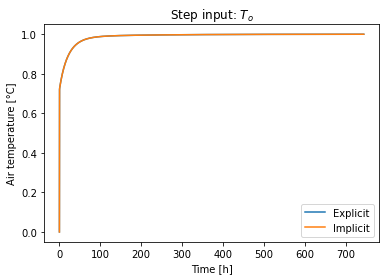

In [56]:
fig, ax = plt.subplots()
ax.plot(t / 3600, temp_exp[-1, :], t / 3600, temp_imp[-1, :])
ax.set(xlabel='Time [h]', ylabel='Air temperature [°C]', title='Step input: $T_o$')
ax.legend(['Explicit', 'Implicit'])

### Step input: indoor heat flow $Q_h$

Let's consider that the outdoor temperature $Q_h$ has a step variation of 1 W (the outdoor temperature is zero, $T_o = 0$):

In [57]:
u = np.block([[np.ones([8, n])],
              [np.zeros([11, n])]])

We initialize again to zero the temperature vector for explicit and implicit Euler.

In [58]:
temp_exp = np.zeros([no_t, t.shape[0]])
temp_imp = np.zeros([no_t, t.shape[0]])

The formula for Euler forward (or explicit) integration is
$$ \theta_{k+1} = (I + \Delta t A) \theta _k + \Delta t B u_k $$
and for Euler backward (or implicit) integration it is
$$\theta_{k+1} = (I - \Delta t A)^{-1} ( \theta _k + \Delta t B u_k )$$

In [59]:
for k in range(t.shape[0] - 1):
    temp_exp[:, k + 1] = (np.eye(no_t) + dt * As) @\
        temp_exp[:, k] + dt * Bs @ u[:, k]
    temp_imp[:, k + 1] = np.linalg.inv(np.eye(no_t) - dt * As) @\
        (temp_imp[:, k] + dt * Bs @ u[:, k])

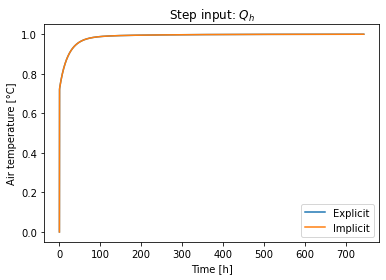

In [60]:
fig, ax = plt.subplots()
ax.plot(t / 3600, temp_exp[-1, :], t / 3600, temp_imp[-1, :])
ax.set(xlabel='Time [h]', ylabel='Air temperature [°C]', title='Step input: $Q_h$')
ax.legend(['Explicit', 'Implicit'])

### Simulation with outdoor temperature, $T_o$, from Zermatt weather data

Time vector (in seconds) for weather data:

In [61]:
# time for weather (in seconds)
tw = np.arange(0, 3600 * T_out.shape[0], 3600)
# change the timestep from 1h to dt
t = np.arange(0, 3600 * T_out.shape[0], dt)
# outdoor temperature at timestep dt
T0 = np.interp(t, tw, T_out['temp_air'])
n_T = T0.shape[0]

For this preliminary analysis the goal temperature is chosen to be $Tsp$ = 20°C, the heat flow given from the fan $Q_a$ is considered to be constant and equal to 2000W and the heat flow from the people inside the chalet $Qpp$ is considered to be approximately 360W.

In [62]:
Tsp = 20*np.ones([1, n_T])
Qa = 2000
Qpp = 360

radN = np.interp(t, tw, rad_N['WData'])
radE = np.interp(t, tw, rad_E['WData'])
radS = np.interp(t, tw, rad_S['WData'])
radW = np.interp(t, tw, rad_W['WData'])
radER = np.interp(t, tw, rad_ER['WData'])
radWR = np.interp(t, tw, rad_WR['WData'])

n_r = radS.shape[0]
radP = tau*radS/6 + Qpp*np.ones([1, n_r])
rad_in = Qa*np.ones([1, n_r]) + radP

The input vector $u$ is defined from outdoor temperature, goal temperature and obtained heat flows on the nodes:

In [63]:
u = np.block([[T0],
              [T0],
              [T0],
              [T0],
              [T0],
              [T0],
              [T0],
             [Tsp],
             [alpha_wood*radN],
             [tau*radS/6],
             [alpha_wood*radE],
             [tau*radS/6],
             [alpha_wood*radW],
             [tau*radS/6],
             [alpha_beech*radER],
             [tau*radS/6],
             [alpha_beech*radWR],
             [tau*radS/6],
             [rad_in]])

The temperature vectors for explicit and implicit Euler are initialized and integrated.

In [64]:
temp_exp = np.zeros([no_t, n])
temp_imp = np.zeros([no_t, n])
temp_exp = np.zeros([no_t, t.shape[0]])
temp_imp = np.zeros([no_t, t.shape[0]])

for k in range(n - 1):
    temp_exp[:, k + 1] = (np.eye(no_t) + dt * As) @\
        temp_exp[:, k] + dt * Bs @ u[:, k]
    temp_imp[:, k + 1] = np.linalg.inv(np.eye(no_t) - dt * As) @\
        (temp_imp[:, k] + dt * Bs @ u[:, k])

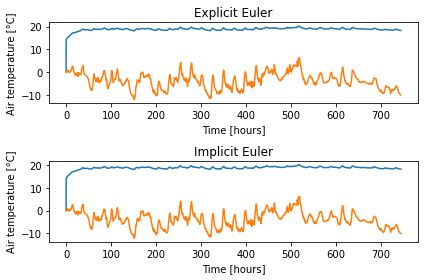

In [65]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(t / 3600, temp_exp[-1, :],
               t / 3600, T0)
axs[0].set_xlabel('Time [hours]')
axs[0].set_ylabel('Air temperature [°C]')
axs[0].set_title('Explicit Euler')

axs[1].plot(t / 3600, temp_imp[-1, :],
               t / 3600, T0)
axs[1].set_xlabel('Time [hours]')
axs[1].set_ylabel('Air temperature [°C]')
axs[1].set_title('Implicit Euler')

fig.tight_layout()

## Remarks

The time step depends on:

- P-controller gain `Kp`:
    -  $K_p \rightarrow \infty$, then the controller is perfect and the time step needs to be small;
- Capacities considered into the model:
    - if the capacities of the air $C_a =$ `C['Air']` and $C_g =$ `C['Glass']`are considered, then the time step is small;
    
The controller models an HVAC system capable to heat (when $q_{HVAC} > 0$) and to cool $q_{HVAC} < 0$).

**References**

C. Ghiaus (2013) Causality issue in the heat balance method for calculating the design heating and cooling loads, *Energy* 50: 292-301, https://doi.org/10.1016/j.energy.2012.10.024

# Simulation with feedback control system

A feedback control system is a system whose output is controlled using its measurement as a feedback signal. This feedback signal is compared with a reference signal to generate an error signal which is filtered by a controller to produce the system's control input.

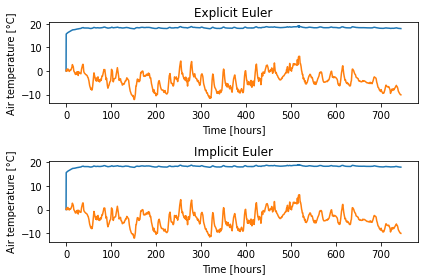

In [66]:
# initial values for temperatures obtained by explicit and implicit Euler
# initial values for temperatures obtained by explicit and implicit Euler
temp_exp = np.zeros([no_t, n])
temp_imp = np.zeros([no_t, n])
temp_exp = np.zeros([no_t, t.shape[0]])
temp_imp = np.zeros([no_t, t.shape[0]])

Tisp = 20
DeltaT = 1
y = np.zeros(u.shape[1], dtype=object)
y[0] = Tisp
I = np.eye(As.shape[0])
radP = radP.T

for k in range(u.shape[1] - 1):
    # print(k, y[k - 1], temp_exp[2, k])
    if Tisp - DeltaT < y[k - 1] < DeltaT + Tisp:
        u[18, k] = 0
    else:
        u[18, k] = Kp * (Tisp - y[k - 1])
        if u[18, k] - radP[k] > 5000:
            u[18, k] = 5000 + radP[k]
        
    temp_exp[:, k + 1] = (I + dt * As) @ temp_exp[:, k]\
        + dt * Bs @ u[:, k]
    y[k] = Cs[1, :] @ temp_exp[:, k] + Ds[1, :] @ u[:, k]
    temp_imp[:, k + 1] = np.linalg.inv(np.eye(no_t) - dt * As) @\
        (temp_imp[:, k] + dt * Bs @ u[:, k])
        
fig2, axs2 = plt.subplots(2, 1)

q_HVAC = u[18, :] - radP

axs2[0].plot(t / 3600, temp_exp[-1, :],
               t / 3600, T0)
axs2[0].set_xlabel('Time [hours]')
axs2[0].set_ylabel('Air temperature [°C]')
axs2[0].set_title('Explicit Euler')

axs2[1].plot(t / 3600, temp_imp[-1, :],
               t / 3600, T0)
axs2[1].set_xlabel('Time [hours]')
axs2[1].set_ylabel('Air temperature [°C]')
axs2[1].set_title('Implicit Euler')
fig2.tight_layout()


# Simulation with a predictive control system

Predictive control is a control algorithm based on a predictive model of the process. The model is used to predict the future output based on historical information about the process, as well as anticipated future input. It emphasizes the function of the model, not the structure of the model.

To account for a feasible solution, the fan effort is limited to a maximum of 5000 W.

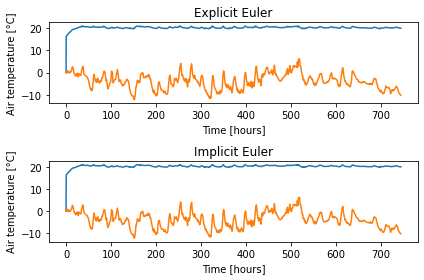

In [67]:
# initial values for temperatures obtained by explicit and implicit Euler
temp_exp = np.zeros([no_t, n])
temp_imp = np.zeros([no_t, n])
temp_exp = np.zeros([no_t, t.shape[0]])
temp_imp = np.zeros([no_t, t.shape[0]])

Tisp = 20
DeltaT = 1
y = np.zeros(u.shape[1], dtype=object)
y[0] = Tisp
I = np.eye(As.shape[0])

for k in range(u.shape[1] - 1):
    if (y[k] < Tisp or y[k] > DeltaT + Tisp) and abs(Tisp - y[k]) > 0.2:
        u[18, k] += Kp * (Tisp - y[k])
        u[18, k] = u[18, k] + radP[k]
        
        if u[18, k] - radP[k] > 5000:
            u[18, k] = 5000 + radP[k]
    else:
        u[18, k] = u[18, k]

    temp_exp[:, k + 1] = (I + dt * As) @ temp_exp[:, k]\
        + dt * Bs @ u[:, k]
    y[k + 1] = Cs[1, :] @ temp_exp[:, k + 1] + Ds[1, :] @ u[:, k]
    temp_imp[:, k + 1] = np.linalg.inv(np.eye(no_t) - dt * As) @\
        (temp_imp[:, k] + dt * Bs @ u[:, k])
    u[18, k + 1] = u[18, k]
   
q_HVAC = u[18, :] - radP.T[:]
    
fig3, axs3 = plt.subplots(2, 1)

axs3[0].plot(t / 3600, temp_exp[-1, :],
               t / 3600, T0)
axs3[0].set_xlabel('Time [hours]')
axs3[0].set_ylabel('Air temperature [°C]')
axs3[0].set_title('Explicit Euler')

axs3[1].plot(t / 3600, temp_imp[-1, :],
               t / 3600, T0)
axs3[1].set_xlabel('Time [hours]')
axs3[1].set_ylabel('Air temperature [°C]')
axs3[1].set_title('Implicit Euler')
fig3.tight_layout()


# Discussion of the results and Conclusion

Finally, the most important differences between the three control systems analysed (proportional, feedback and predictive controllers), along with the influence of some parameters (blinds) are discussed:

First of all, the choice of the constrol system has an important impact on the thermal management of the building itself. 
In particular:

   - With the first controller tested (a simple proportional controller), its performance depends on the choice of Kp. If Kp is      too high, the control system tends to be too sensitive against temperature gradients. On the other hand, a low Kp leads to      a control system which is not capable to adjust efficiently the indoor temperature. In general, the proportional controller is cheaper, but less efficient in comparison to the other systems. the value of Kp is an intermediate value to exploit the advantages of the proportion controller while staying in feasible and approximately constant control heat flow. 
   - With the second controller considered (control system with feedback), it could be noticed from the corresponding figure that is more efficient and accurate in comparison to the proportional controller. However, it is still not capable to be in a suitable range of the temperature set-point, which means if we choose a Tsp = 20°C, the control system will manage to set the temperature always below 20°C, which is not the suitable setting.
   - With the third and last controller (predictive control system), we have a more complex (and expensive) control system, which delivers a more efficient and accurate control on the temperature set-point. As shown in the previous charts, this system is very stable and has a narrow range of variation around the chosen set-point. It is the best among the control systems considered here. 
   
Secondly, it was observed that some parameters show a certain influence on the results (albedo, blinds tilt, radiative properties of materials, heat rate of the HVAC system), which affects in some level the thermal behaviour of the building itself depending on the paramenter. The graphs obtained for the transmission cpefficient reduction (blinds closed), for example, show a very small difference with respect to the nominal analysis, suggesting a very mild influence on the control effort that has to be applied.

It was also studied the effect of the outdoor conditions (extracted from the .epw file) on the heat rate generated by the HVAC system located inside the chalet (see figures below). As shown, in order to keep constant the indoor temperature setpoint chosen (in this case 20 °C), the heat rate from the HVAC system varies accordingly to the outdoor condition. In this test, also the outdoor radiative quantities are taken into account. Finally, it is remarkable to outline that these HVAC systems really work in this way: they have an embedded control system which allows to adjust the heat/cool generated in order to mantained the user-defined indoor conditions.

![cube](heat_flow.JPG)

Finally, from this project it is proved that, through computational approaches, the thermal energy management of a chosen building can be easily exploited, allowing also to vary some relevant parameters in order to study the response of the building. Then, corrective actions can be taken by the engineers in order to optimise the energy consumption, for example by changing the materials of the wall, changing the control system or choosing a different HVAC system. This computational approach can be easily integrated with other design approaches, such as simulations with standard softwares or on-site inspections.  